# Random Forest Analysis

In [155]:
import os
import random
from itertools import combinations

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [3]:
random_seed = 303

In [4]:
# input
fn_traning_set = '../data/intermediary/training_set.csv.gz'
fn_pairwise = '../data/intermediary/pairwise_training_set.csv.gz'

# output
table2 = f'../data/output/tables/table2.csv'
fn_permutations = 'f../data/appendix/ablation_feature_permutations.csv'
fn_ablation = f'../data/output/tables/tableTK.csv'
fn_single_feature = f'../data/output/tables/tableTK.csv'
fn_feature_importance = f'../data/output/figures/figTK.png'

## Feature Engineering

In [5]:
df = pd.read_csv(fn_traning_set, compression='gzip')

In [6]:
_df = df[
    (~df.stars.isnull()) & 
    (~df.reviews.isnull()) & 
    (df.is_sponsored == False) &
    (~df.is_sold_by_amazon.isnull()) &
    (~df.is_shipped_by_amazon.isnull()) &
    (~df.has_third_party_sellers.isnull()) &
    (~df.price.isnull())
]
len(_df)

176935

In [7]:
_df['price'] = _df.price.apply(lambda x: x.split(' ')[-1].lstrip("$") if x else None)
_df['price'] = _df['price'].str.replace(',', '').astype(float)

<ipython-input-7-14ad5d1093e7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['price'] = _df.price.apply(lambda x: x.split(' ')[-1].lstrip("$") if x else None)
<ipython-input-7-14ad5d1093e7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df['price'] = _df['price'].str.replace(',', '').astype(float)


In [8]:
_df = _df.sort_values(by=['search_term', 'product_order']).drop_duplicates(subset=['search_term', 'asin'])

In [9]:
_df.loc[:, 'reviews_log'] = np.log(_df['reviews'])
_df.loc[:, 'stars_norm'] = _df['stars'] / 5
_df.loc[:, 'product_order_log'] =  np.log(_df['product_order'])
_df.loc[:, 'product_row'] = ( (_df['product_order'] // 4) + 1)

In [10]:
_df['control'] = np.random.randn(len(_df))

In [11]:
bool_cols = [
    'top_clicked',
    'is_sold_by_amazon', 
    'is_shipped_by_amazon', 
    'is_amazon', 
    'top_clicked',
    'is_best_seller',
    "is_amazons_choice"
]
bool2int = {True : 1, False : -1}
for col in bool_cols:
    _df.loc[:, col + '_encoded'] = _df[col].replace(bool2int)

In [44]:
last_product_position = 2

In [162]:
def produce_training_set(_df, last_product_position = 2, random_seed=303):
    random.seed(random_seed)
    data = []
    for search_term, __df in tqdm(_df[_df.is_sponsored != True].groupby('search_term')):
        # for each search term, go through each row.
        if len(__df) == 1:
            continue
        if len(__df[__df.product_order == 1]) == 0:
            continue
        __df = __df.sort_values(by='product_order')
        __df = __df.reset_index()

        for i in range(1, last_product_position):
            if len(__df) <= i:
                continue
            if random.random() > .5:
                row = __df.iloc[0]
                comparison = __df.iloc[i]
            else:
                row = __df.iloc[i]
                comparison = __df.iloc[0]
            
            knockout = row['product_order']
            # calculate differences between two pairs
            placed_higher = knockout > comparison['product_order']
            stars_delta = row['stars'] - comparison['stars']
            ratings_delta = row['reviews'] - comparison['reviews']
            stars_delta_perc = stars_delta / row['stars']
            ratings_delta_perc = ratings_delta / row['reviews']

            is_amazon = row['is_amazon_encoded'] - comparison['is_amazon_encoded']
            is_shipped_by_amazon = row['is_shipped_by_amazon_encoded'] - comparison['is_shipped_by_amazon_encoded']
            is_sold_by_amazon = row['is_sold_by_amazon_encoded'] - comparison['is_sold_by_amazon_encoded']
            is_top_clicked = row['top_clicked_encoded'] - comparison['top_clicked_encoded']
            is_best_seller = row['is_best_seller_encoded'] - comparison['is_best_seller_encoded']
            is_amazons_choice = row['is_amazons_choice_encoded'] - comparison['is_amazons_choice_encoded']
            random_noise = row['control'] - comparison['control']
            price_delta = row['price'] - comparison['price']
            price_delta_perc = (price_delta) / (row['price'] + .001)

            output = {
                'search_term' : search_term,
                'placed_higher' : placed_higher,
                'stars_delta': stars_delta,
                'reviews_delta' : ratings_delta,
                'price_delta': price_delta,
                'stars_delta_perc': stars_delta_perc,
                'reviews_delta_perc': ratings_delta_perc,
                'price_delta_perc': price_delta_perc,
                'is_shipped_by_amazon' : is_shipped_by_amazon,
                'is_sold_by_amazon': is_sold_by_amazon,
                'is_amazon': is_amazon,
                'is_top_clicked': is_top_clicked,
                'is_amazons_choice': is_amazons_choice,
                'is_best_seller': is_best_seller,
                'random_noise' : random_noise,
                'asin_1' : row['asin'],
                'asin_2': comparison['asin']
            }

            data.append(output)
        training_data = pd.DataFrame(data)
    return training_data

In [164]:
trainig_data = produce_training_set(_df, last_product_position=2)

100%|██████████| 4525/4525 [00:10<00:00, 417.83it/s]


In [16]:
len(training_data)

1667

In [163]:
training_data.placed_higher.value_counts(normalize=True)

True     0.516497
False    0.483503
Name: placed_higher, dtype: float64

In [48]:
training_data

,search_term,placed_higher,stars_delta,reviews_delta,is_shipped_by_amazon,is_sold_by_amazon,is_amazon,is_top_clicked,is_amazons_choice,is_best_seller,random_noise,price_difference,asin_1,asin_2
0,#10 envelope,True,0.0,-1654.0,0,0,-2,0,0,2,0.248205,-11.00,B01D0OANU4,B06VVLD2GL
1,#6 envelope,False,0.1,7844.0,0,0,2,2,0,0,0.539421,-6.12,B06X15WSLL,B07JNXMBSX
2,1 inch binder,True,0.0,-9383.0,0,2,-2,0,2,-2,-0.688909,10.72,B00A45VF2S,B01BRGTWOA
3,1% milk,False,0.0,183.0,0,0,0,2,0,0,-0.660239,1.10,B07WC9MMPD,B07W5Z8SJ8
4,10 dollar gifts,False,0.8,75410.0,-2,0,0,0,0,-2,-0.350984,0.01,B00F4CEHNK,B07FCNYND8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1662,zwave hub,False,0.8,848.0,0,0,0,2,0,0,-2.192503,98.00,B07D19VVTX,B077Y939JQ
1663,zxzy womens hoodies,False,-0.1,6.0,0,0,0,0,0,0,0.923685,8.00,B08F7RFZGP,B08KT3BD2X
1664,zyliss knives,True,0.0,-3010.0,0,0,0,0,-2,0,0.095042,-8.00,B0753SKVZX,B01DKEB5OC
1665,zyrtec for kids,False,-0.2,2184.0,2,0,0,0,2,0,-1.782325,3.54,B004E0QGOQ,B088X7151W


In [17]:
x, y = train_test_split(training_data, test_size=.2)
len(x), len(y)

(1333, 334)

## Gridsearch
We use gridsearch with 5-fold cross validation to determine the optimal hyperparameters.

In [31]:
random_seed = 303
parameters = {'n_estimators':(100, 300, 500), 'max_depth':[3,5,7,9], 'random_state':[random_seed]}

In [33]:
forest = RandomForestClassifier()
grid = GridSearchCV(forest, parameters, n_jobs=-1, cv=5)
X_train, X_test, y_train, y_test = train_test_split(training_data[cols],
                                                    training_data[target],
                                                    test_size=.25, random_state=random_seed)
grid.fit(X_train, y_train)

In [35]:
grid.score(X_test, y_test)

0.7314148681055156

In [36]:
grid.best_params_

{'max_depth': 7, 'n_estimators': 300, 'random_state': 303}

In [16]:
training_data.iloc[0]

search_term             #10 envelope
placed_higher                   True
stars_delta                        0
reviews_delta                  -1654
is_shipped_by_amazon               0
is_sold_by_amazon                  0
is_amazon                         -2
is_top_clicked                     0
is_amazons_choice                  0
is_best_seller                     2
random_noise               -0.882479
asin_1                    B01D0OANU4
asin_2                    B06VVLD2GL
Name: 0, dtype: object

In [37]:
grid.best_score_

0.7584

## Alation Study

In [71]:
def fit_model_cv(df, variable, target, model, cv=10):
    """Fits a model and gets mean accuracy from k-folds cross validation"""
    is_multivariate = True if isinstance(variable, list) else False   
    X = df[variable]
    y = df[target]
    X_2d = X if is_multivariate else np.expand_dims(X.values, axis=1)  
    scores = cross_val_score(model, X, y, cv=cv)
    accuracy = scores.mean()
    std = scores.std()
    return accuracy, std

In [48]:
def fit_model(df, variable, 
              target, model, cv=10):
    """Fits a model and gets accuracy"""
    is_multivariate = True if isinstance(variable, list) else False   
    X = df[variable]
    y = df[target]
    X_2d = X if is_multivariate else np.expand_dims(X.values, axis=1)  
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_2d, y, random_state=random_seed, test_size=.2,
    )
    model.fit(X_train, y_train)
    accuracy = model.score(X_test, y_test)
    
    return accuracy, _

In [146]:
def get_performance(cat2performance, knockout=['Change of Accuracy_abs']):
    """
    Converts a performance dictionary to a table
    """
    perf = pd.DataFrame([
        {"Feature": k, "Accuracy" :v} for k, v in cat2performance.items()
    ])
    perf['Change of Accuracy'] = perf['Accuracy'].apply(lambda x: x - perf['Accuracy'].iloc[0]) * 100
    perf['Change of Accuracy_abs'] = perf['Accuracy'].apply(lambda x: 
                                                         round(abs(x - perf['Accuracy'].iloc[0]), 2)) * 100                                                
    perf.sort_values(by=['Change of Accuracy_abs', 'Feature'], ascending=False, inplace=True)
    perf = perf[[c for c in perf.columns if c not in knockout]]
    return perf.style.format({
        'Accuracy': '{:,.1%}'.format,
        'Change of Accuracy': '{:.1f}'.format,
    })

In [136]:
cols = ['stars_delta', 'reviews_delta',
        'is_amazon',
       'is_shipped_by_amazon', 'is_sold_by_amazon', 
        'is_top_clicked',
        'random_noise']

target = 'placed_higher'

In [139]:
n_trees = 300
max_tree_depth = 7

In [138]:
cat2performance = {}

forest = RandomForestClassifier(n_estimators=n_trees, max_depth=max_tree_depth, 
                                n_jobs=-1, random_state=303)
score, std = fit_model_cv(training_data, variable=cols, target=target, model=forest)
print(f"All features (n_test = {int(len(training_data) * .2):,}): {score * 100 :.4}%")
cat2performance["All Features"] = score
for col in cols:
    clf =  RandomForestClassifier(n_estimators=n_trees, max_depth=max_tree_depth,
                                  n_jobs=-1, random_state=303)
    # knock out the column
    iv = [c for c in cols if c not in col]
    score, std = fit_model_cv(training_data, variable=iv, target=target, model=clf)
    print(f"without {col}: {score * 100 :.4}% +/- {std * 100 :.2}")
    cat2performance[f"without {col}"] = score

All features (n_test = 333): 75.82%
without stars_delta: 74.99% +/- 2.713
without reviews_delta: 73.12% +/- 2.569
without is_amazon: 64.55% +/- 2.264
without is_shipped_by_amazon: 75.29% +/- 2.454
without is_sold_by_amazon: 75.23% +/- 2.576
without is_top_clicked: 76.19% +/- 2.356
without random_noise: 75.47% +/- 2.537


In [152]:
# cat2performance = {}

# forest = RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=9, random_state=303)
# score = fit_model(training_data, variable=cols, target=target, model=forest)
# print(f"All features (n_test = {int(len(training_data) * .2):,}): {score * 100 :.4}%")
# cat2performance["All Features"] = score
# for col in cols:
#     clf =  RandomForestClassifier(n_estimators=100, n_jobs=-1, max_depth=9, random_state=303)
#     iv = [c for c in cols if c not in col]
#     score = fit_model(training_data, variable=iv, target=target, model=clf)
#     print(f"without {col}: {score * 100 :.4}%")
#     cat2performance[f"without {col}"] = score

All features (n_test = 333): 71.26%
without stars_delta: 73.05%
without reviews_delta: 69.76%
without price_delta: 70.96%
without stars_delta_perc: 70.96%
without reviews_delta_perc: 72.46%
without price_delta_perc: 71.26%
without is_amazon: 61.68%
without is_shipped_by_amazon: 71.56%
without is_sold_by_amazon: 72.75%
without is_top_clicked: 71.26%
without random_noise: 71.56%


In [147]:
get_performance(cat2performance)

,Feature,Accuracy,Change of Accuracy
3,without is_amazon,64.5%,-11.3
2,without reviews_delta,73.1%,-2.7
1,without stars_delta,75.0%,-0.8
5,without is_sold_by_amazon,75.2%,-0.6
4,without is_shipped_by_amazon,75.3%,-0.5
7,without random_noise,75.5%,-0.4
6,without is_top_clicked,76.2%,0.4
0,All Features,75.8%,0.0


In [151]:
cat2performance_standalone = {}

for col in cols:
    clf =  RandomForestClassifier(n_estimators=300, n_jobs=-1, max_depth=7, random_state=303)
    score, std = fit_model_cv(training_data, variable=[col], target=target, model=clf)
    print(f"with just {col}: {score * 100 :.4}% +/- {std * 100 :.2}")
    cat2performance_standalone[f"with just {col}"] = score

with just stars_delta: 52.97% +/- 2.3
with just reviews_delta: 53.39% +/- 3.4
with just is_amazon: 72.17% +/- 3.5
with just is_shipped_by_amazon: 53.69% +/- 2.8
with just is_sold_by_amazon: 58.49% +/- 1.9
with just is_top_clicked: 56.63% +/- 3.7
with just random_noise: 47.45% +/- 4.9


In [152]:
get_performance(cat2performance_standalone, 
                knockout=['Change of Accuracy_abs', 'Change of Accuracy'])

,Feature,Accuracy
2,with just is_amazon,72.2%
6,with just random_noise,47.5%
4,with just is_sold_by_amazon,58.5%
5,with just is_top_clicked,56.6%
3,with just is_shipped_by_amazon,53.7%
0,with just stars_delta,53.0%
1,with just reviews_delta,53.4%


## Ablation study with every possible permutation of the feature sets

In [156]:
permutations = set()
for r in range(len(cols)):
    permutations.update(combinations(cols, r+1))

In [ ]:
cat2performance = {}
for iv in tqdm(perms):
    clf =  RandomForestClassifier(n_estimators=300, max_depth=7, 
                                  n_jobs=-1, random_state=303)
    score, std = fit_model_cv(training_data, variable=list(iv), 
                              target=target, model=clf)
    cat2performance[iv] = score

In [ ]:
df = pd.DataFrame([{"cols" : k, "accuracy": v } for k, v in cat2performance.items()])
df.sort_values("accuracy", inplace=True)

In [ ]:
df.to_csv('../data/output/tables/random_forest_permutations.csv')

## Feature Importance

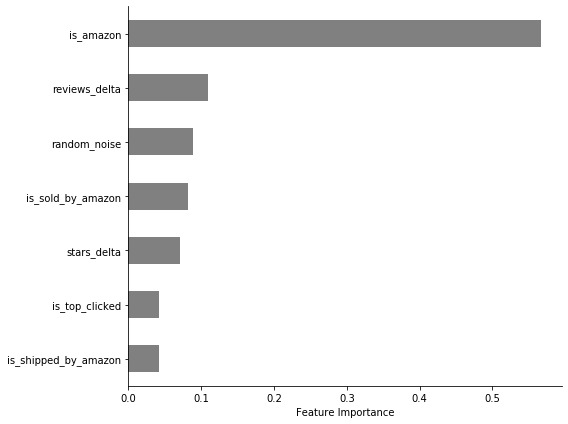

In [153]:
forest = RandomForestClassifier(n_estimators=300, n_jobs=-1, max_depth=7, random_state=303)
score = fit_model(training_data, variable=cols, target=target, model=forest)

feature_names = cols
importances = forest.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
forest_importances.sort_values(inplace=True, ascending=True)

fig, ax = plt.subplots(figsize=(8, 6))
forest_importances.plot.barh(ax=ax, color='grey')
# ax.set_ylabel("Features")
ax.set_xlabel("Feature Importance")

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom') # Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

fig.tight_layout()

## performance predicting who gets placed beyond the second posting


In [169]:
len(trainig_data)

56320

In [ ]:
permformance = []
for n in range(2, 41):
    print(f"Up to {n}...")
    training_data = produce_training_set(_df, last_product_position=n)
    
    cat2performance = {}
    forest = RandomForestClassifier(n_estimators=n_trees, 
                                    max_depth=max_tree_depth, 
                                    n_jobs=-1, random_state=random_seed)
    score, std = fit_model_cv(training_data, variable=cols, target=target, model=forest)
    cat2performance["All Features"] = score
    for col in cols:
        clf =  RandomForestClassifier(n_estimators=n_trees, 
                                      max_depth=max_tree_depth,
                                      n_jobs=-1, random_state=random_seed)
        iv = [c for c in cols if c not in col]
        score, std = fit_model_cv(training_data, variable=iv, target=target, model=clf)
        cat2performance[f"without {col}"] = score
    
    cat2performance["up_to_product"] = n
    permformance.append(cat2performance)

  0%|          | 0/4525 [00:00<?, ?it/s]

Up to 2...


  0%|          | 0/4525 [00:00<?, ?it/s]

Up to 3...


  0%|          | 0/4525 [00:00<?, ?it/s]

Up to 4...


  0%|          | 0/4525 [00:00<?, ?it/s]

Up to 5...


  0%|          | 0/4525 [00:00<?, ?it/s]

Up to 6...


  0%|          | 0/4525 [00:00<?, ?it/s]

Up to 7...


  0%|          | 0/4525 [00:00<?, ?it/s]

Up to 8...


  0%|          | 0/4525 [00:00<?, ?it/s]

Up to 9...


  0%|          | 0/4525 [00:00<?, ?it/s]

Up to 10...


  0%|          | 0/4525 [00:00<?, ?it/s]

Up to 11...


  0%|          | 0/4525 [00:00<?, ?it/s]

Up to 12...


  0%|          | 0/4525 [00:00<?, ?it/s]

Up to 13...


  0%|          | 0/4525 [00:00<?, ?it/s]

Up to 14...


  0%|          | 0/4525 [00:00<?, ?it/s]

Up to 15...


  0%|          | 0/4525 [00:00<?, ?it/s]

Up to 16...


  0%|          | 0/4525 [00:00<?, ?it/s]

Up to 17...


  0%|          | 0/4525 [00:00<?, ?it/s]

Up to 18...


  0%|          | 0/4525 [00:00<?, ?it/s]

Up to 19...


  0%|          | 0/4525 [00:00<?, ?it/s]

Up to 20...


  0%|          | 0/4525 [00:00<?, ?it/s]

Up to 21...


  0%|          | 0/4525 [00:00<?, ?it/s]

Up to 22...


  0%|          | 0/4525 [00:00<?, ?it/s]

Up to 23...


  0%|          | 0/4525 [00:00<?, ?it/s]

Up to 24...


  0%|          | 0/4525 [00:00<?, ?it/s]

Up to 25...


  0%|          | 0/4525 [00:00<?, ?it/s]

Up to 26...


100%|██████████| 4525/4525 [02:44<00:00, 27.45it/s]


In [172]:
df_performance = pd.DataFrame(permformance)

In [173]:
df_performance

,All Features,without stars_delta,without reviews_delta,without is_amazon,without is_shipped_by_amazon,without is_sold_by_amazon,without is_top_clicked,without random_noise,up_to_product
0,0.758239,0.749888,0.731246,0.645495,0.752879,0.752265,0.761857,0.754679,2
1,0.752169,0.756073,0.738070,0.639678,0.754574,0.753069,0.749765,0.754272,3
2,0.758513,0.757111,0.742896,0.639058,0.760112,0.761315,0.756910,0.755508,4
3,0.764666,0.770370,0.745604,0.649711,0.763013,0.764816,0.758662,0.767218,5
4,0.767479,0.769160,0.751019,0.656259,0.768919,0.768199,0.765677,0.767719,6
5,0.774051,0.776854,0.753025,0.654919,0.772751,0.773051,0.769546,0.774251,7
6,0.780207,0.782010,0.756775,0.664607,0.780036,0.779607,0.774284,0.780121,8
7,0.783611,0.784437,0.763932,0.670572,0.784288,0.783611,0.778728,0.784737,9
8,0.784761,0.787032,0.765392,0.676106,0.783959,0.783292,0.779885,0.786097,10
9,0.786088,0.788793,0.761557,0.681898,0.786749,0.785486,0.784464,0.787470,11


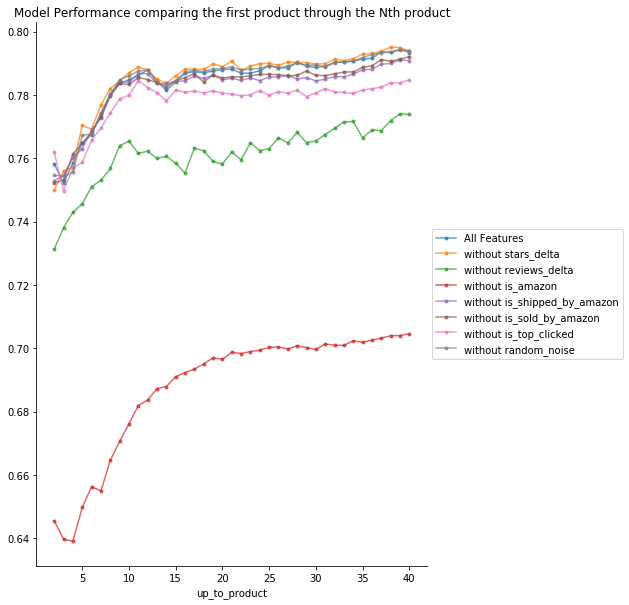

In [195]:
ax = df_performance.set_index('up_to_product').plot(figsize=(7, 10),
                                                    kind='line',
                                                    alpha=.7,
                                                    style='.-',
                                                    title="Model Performance comparing the first product through the Nth product")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

## Distributions of features:

0 means they are both X
-2 means they are both NOT X
2 means one is X and one is NOT X

In [166]:
training_data['is_amazon'].value_counts(normalize=True)

 0    0.486465
 2    0.257787
-2    0.255748
Name: is_amazon, dtype: float64

In [167]:
training_data['is_shipped_by_amazon'].value_counts(normalize=True)

 0    0.706770
 2    0.147393
-2    0.145837
Name: is_shipped_by_amazon, dtype: float64

In [168]:
training_data['is_sold_by_amazon'].value_counts(normalize=True)

 0    0.536012
 2    0.232663
-2    0.231325
Name: is_sold_by_amazon, dtype: float64

In [169]:
training_data['is_best_seller'].value_counts(normalize=True)

 0    0.844497
-2    0.078748
 2    0.076755
Name: is_best_seller, dtype: float64

In [170]:
training_data['is_top_clicked'].value_counts(normalize=True)

 0    0.609016
-2    0.196006
 2    0.194978
Name: is_top_clicked, dtype: float64

In [171]:
training_data['is_amazons_choice'].value_counts(normalize=True)

 0    0.882835
 2    0.060038
-2    0.057127
Name: is_amazons_choice, dtype: float64